In [153]:
# 표준 라이브러리
import os
import random

# 데이터 처리 및 분석 라이브러리
import numpy as np
import pandas as pd
import duckdb

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt


# 진행상황 표시 라이브러리
from tqdm import tqdm

# 머신러닝 관련 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#모델
import lightgbm as lgbm
import xgboost as xgb

# data load

In [154]:
train = duckdb.query("""
    SELECT * 
    FROM '../data/train.csv'
""").to_df()

test = duckdb.query("""
    SELECT * 
    FROM '../data/test.csv'
""").to_df()

train = train.drop(columns='ID')
test = test.drop(columns='ID')
target = train['target']

print(train.shape)
print(test.shape)

(21693, 53)
(15004, 52)


In [155]:
print(train.describe())
print(train.info())

               X_01          X_02          X_03          X_04          X_05  \
count  21693.000000  21693.000000  21693.000000  21693.000000  21693.000000   
mean       0.017989      0.258061      0.533411      0.510776      0.421508   
std        0.004794      0.064098      0.057962      0.082500      0.168995   
min       -0.003000      0.000000      0.000000      0.000000      0.000000   
25%        0.015000      0.244223      0.510506      0.507370      0.363789   
50%        0.018000      0.247364      0.535398      0.520045      0.378157   
75%        0.021000      0.251002      0.560651      0.533285      0.393900   
max        0.037000      1.000000      1.000000      1.000000      1.000000   

               X_06          X_07          X_08          X_09          X_10  \
count  21693.000000  21693.000000  21693.000000  21693.000000  21693.000000   
mean       0.600059      0.618569      0.534465      0.550514      0.517199   
std        0.082645      0.139561      0.153934    

# EDA

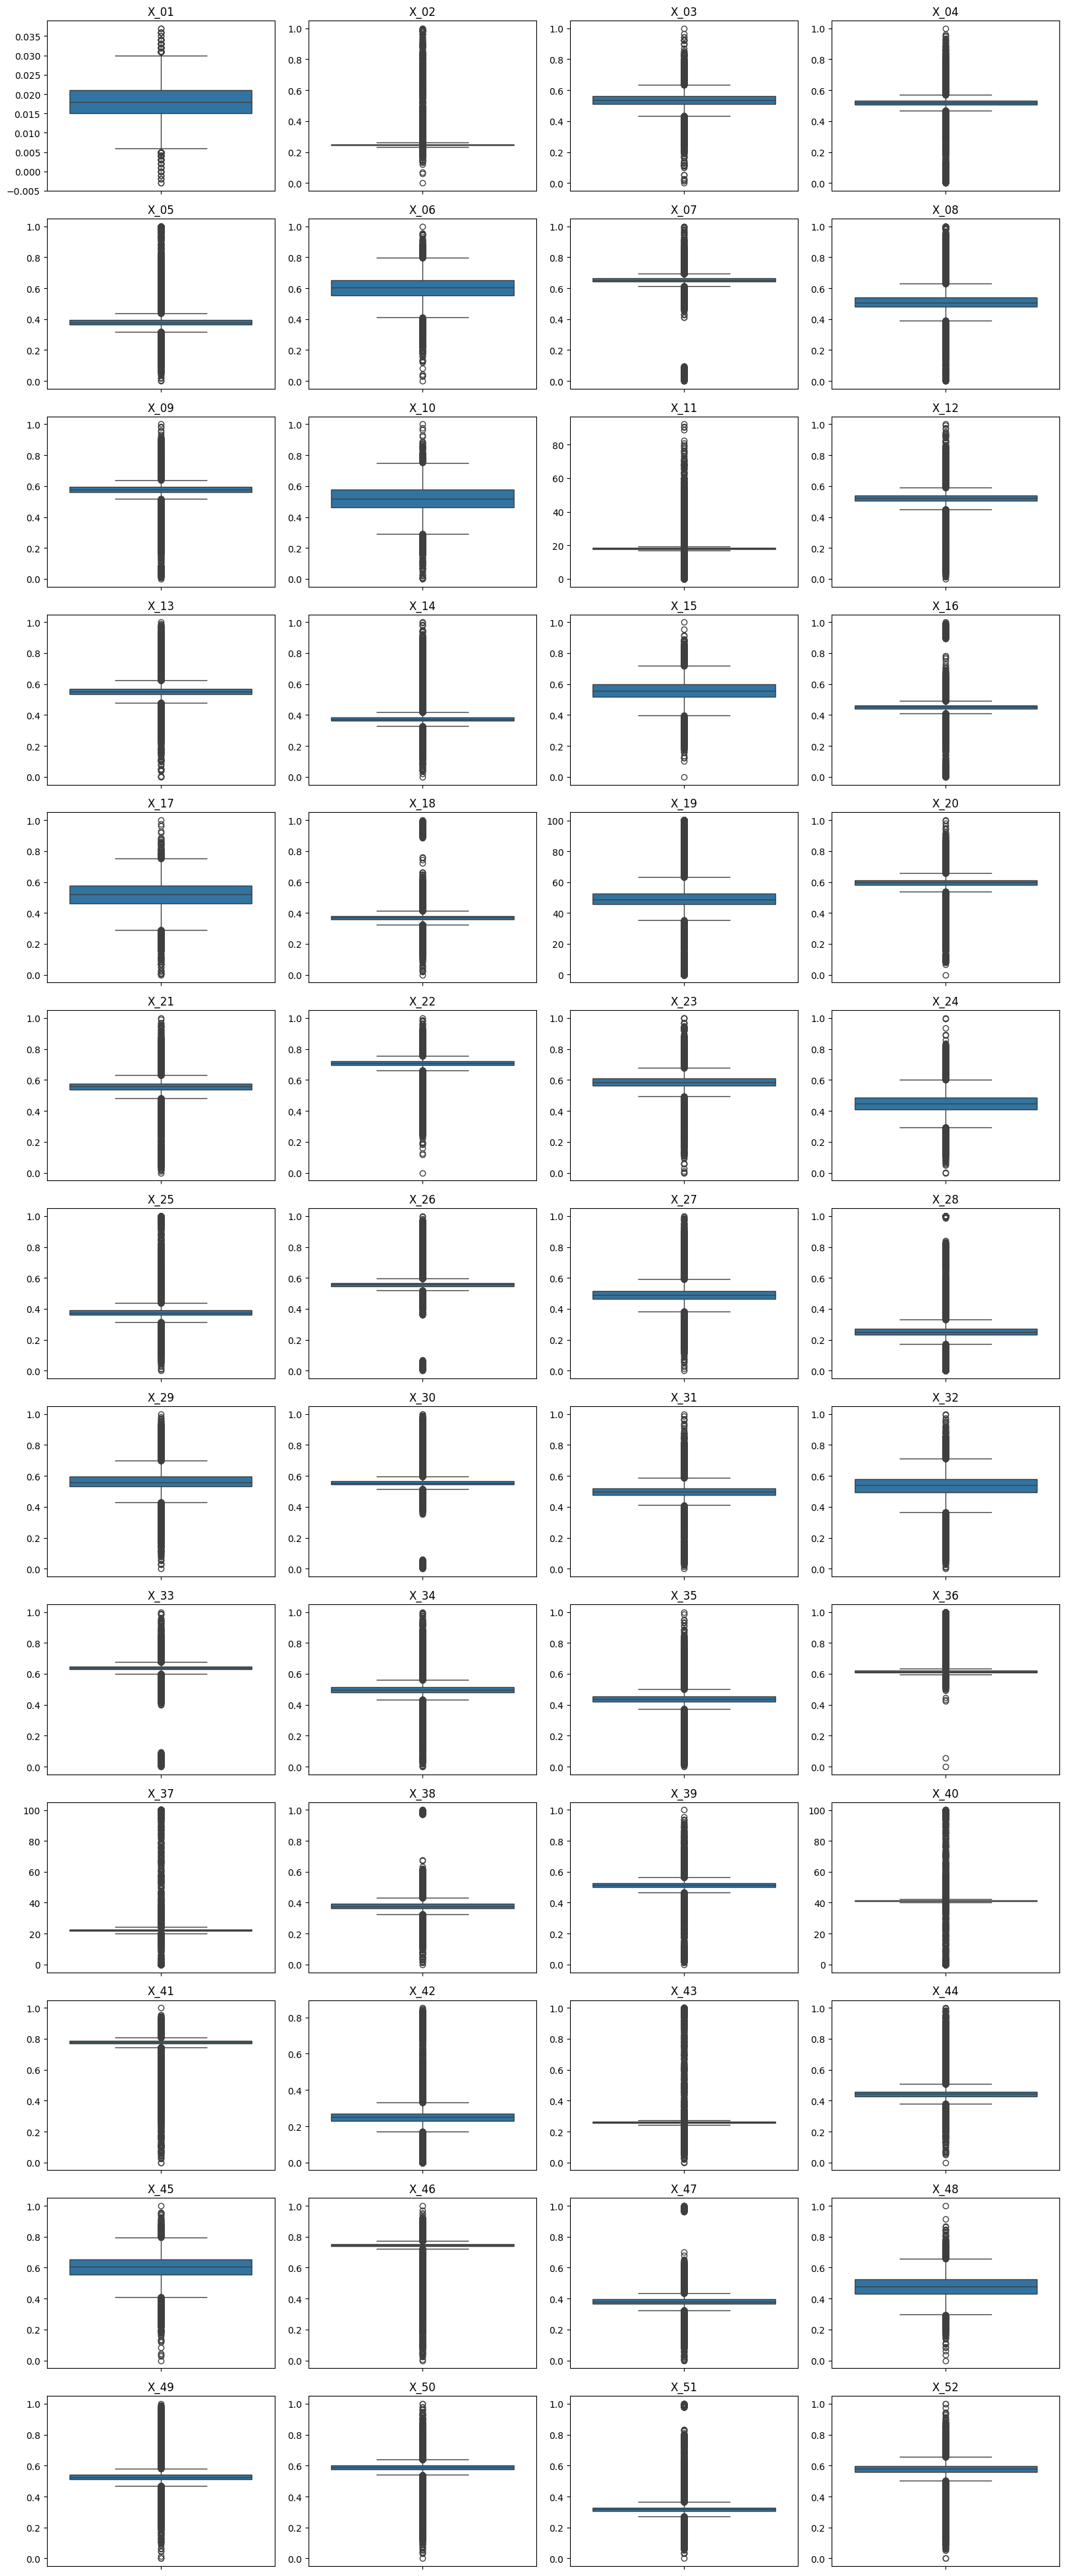

In [156]:
# trian 확인
cols = [f'X_{str(i).zfill(2)}' for i in range(1, 53)]
num_cols = 4  # 한 행에 몇 개의 그래프를 그릴지
num_rows = (len(cols) + num_cols - 1) // num_cols  # 필요한 행 수 계산

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*3))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(data=train, y=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# 남는 subplot 영역은 삭제 또는 가리기
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [157]:
print(train['target'].value_counts().sort_index())
# 모두 비율 동일

target
0     1033
1     1033
2     1033
3     1033
4     1033
5     1033
6     1033
7     1033
8     1033
9     1033
10    1033
11    1033
12    1033
13    1033
14    1033
15    1033
16    1033
17    1033
18    1033
19    1033
20    1033
Name: count, dtype: int64


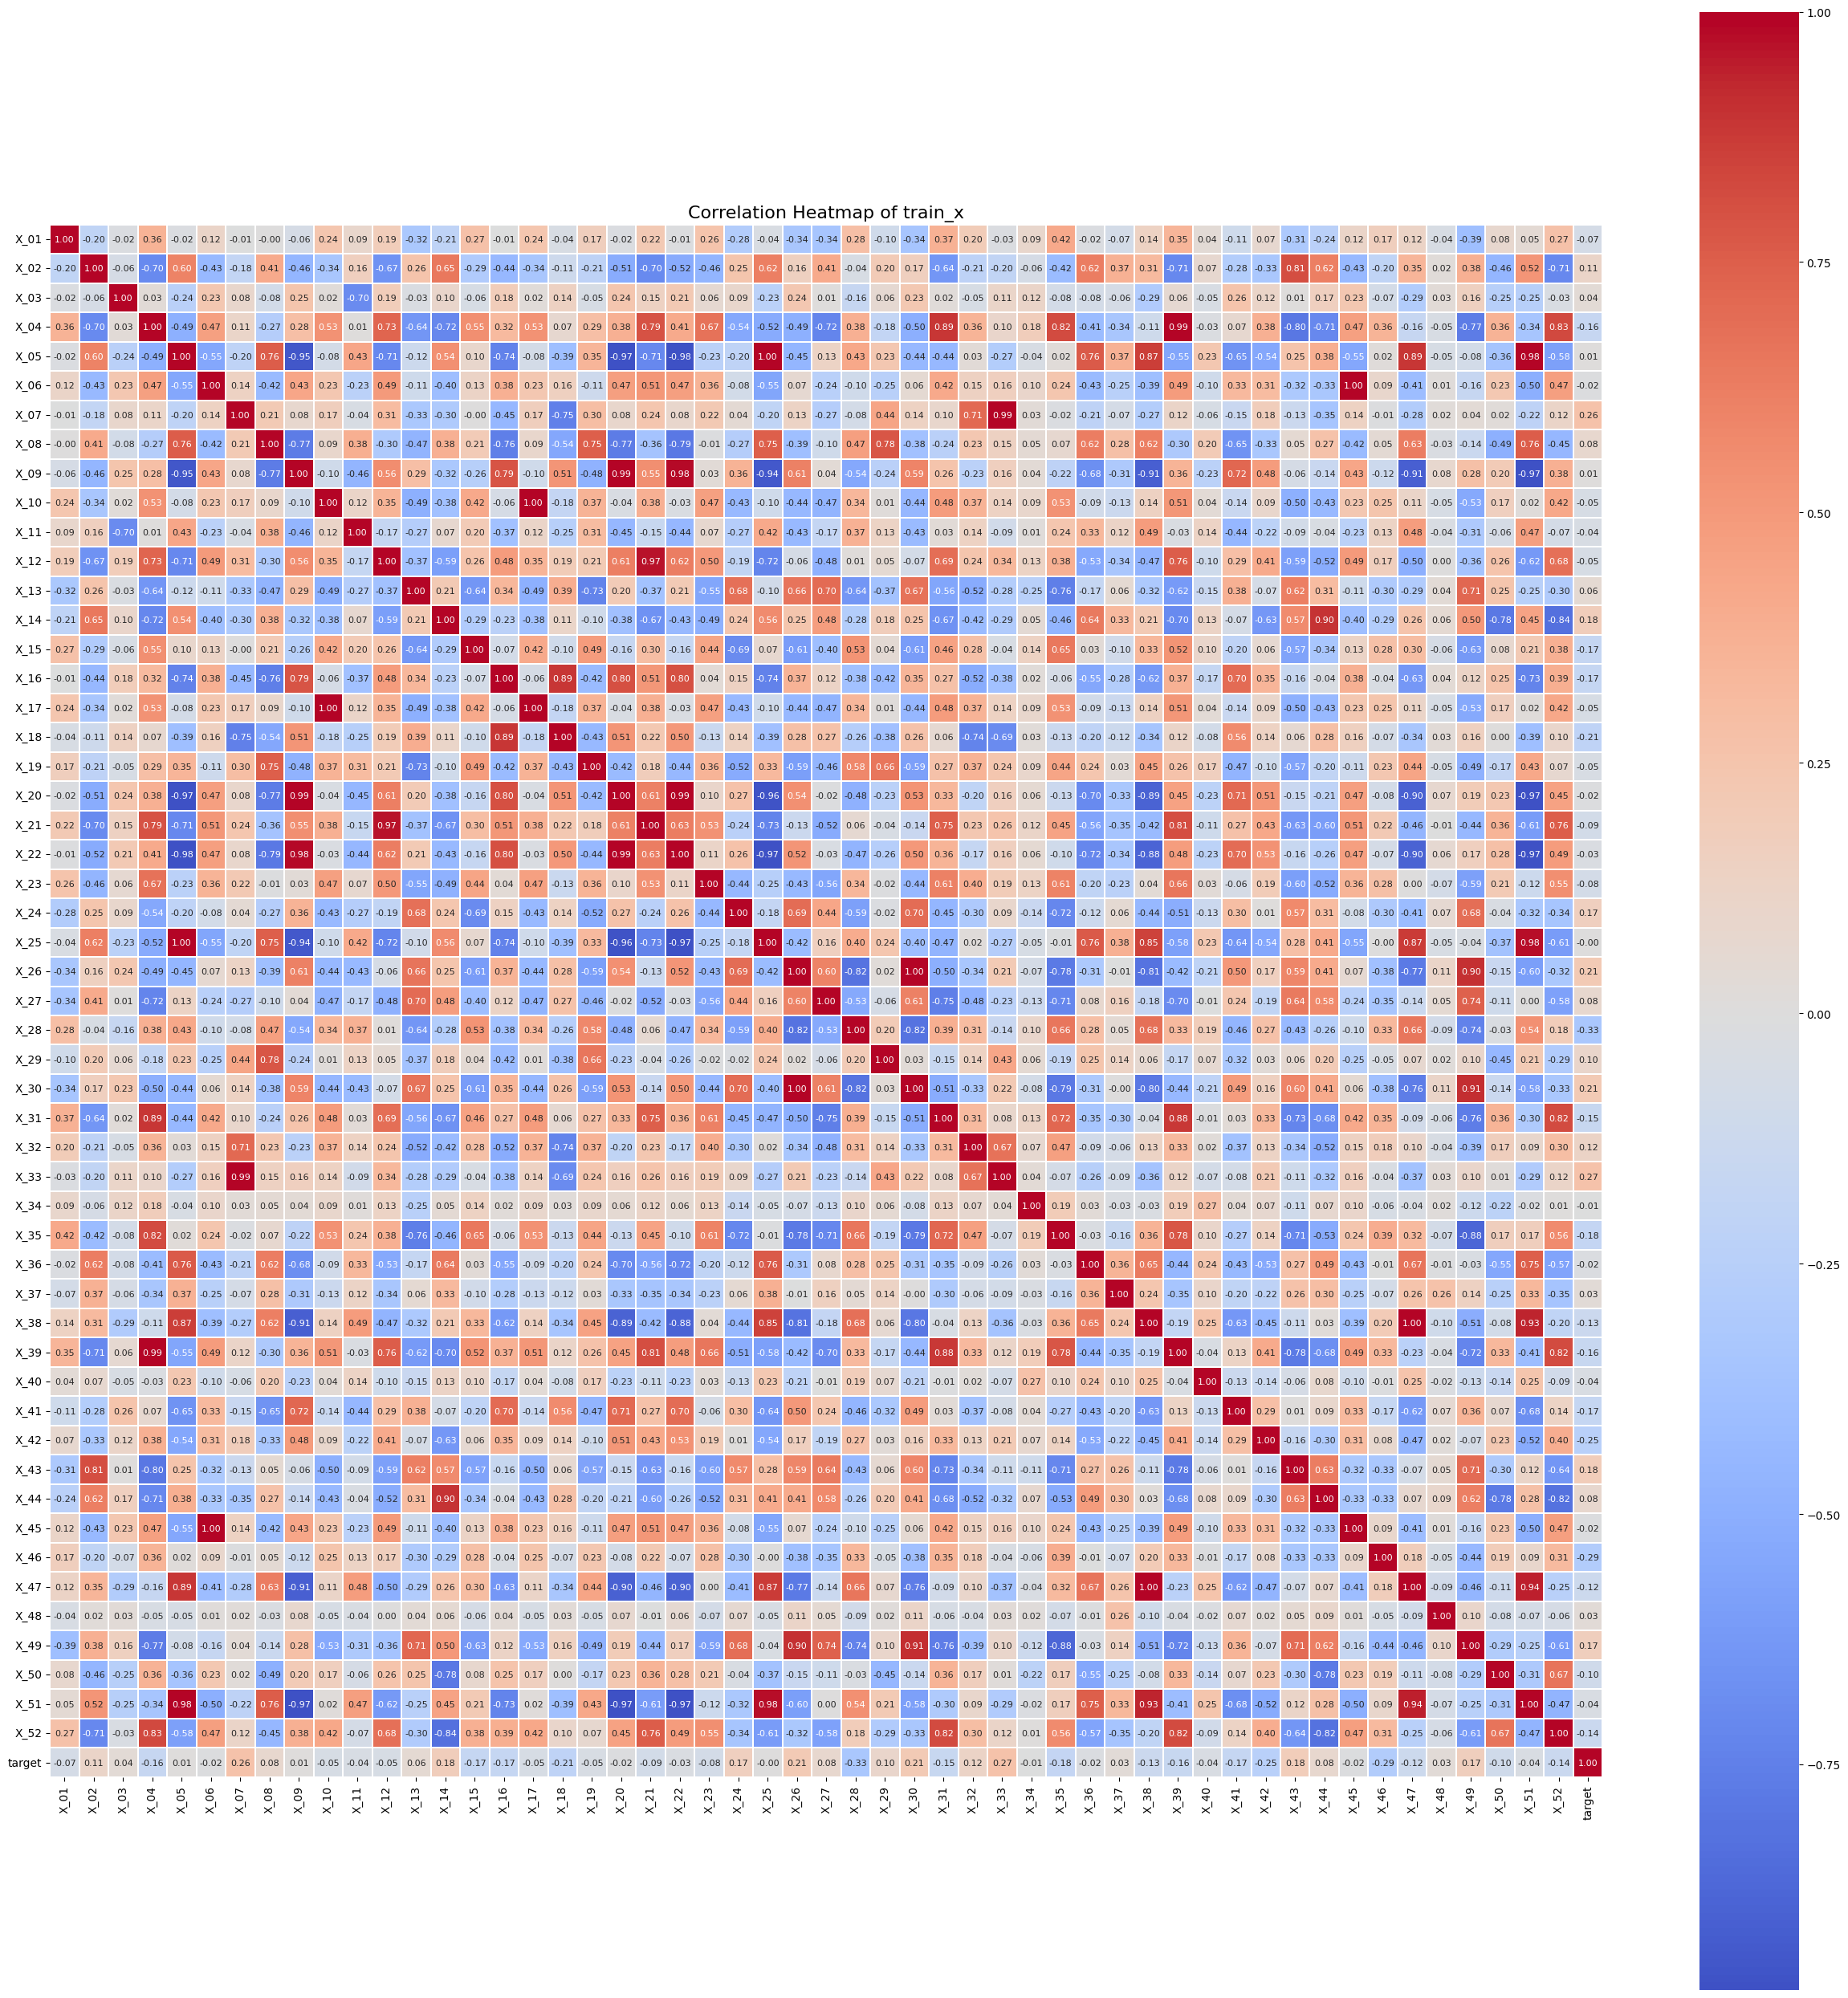

In [158]:
# 상관관계 heatmap 그리기
def plot_correlation_heatmap(df):
    # 상관관계 매트릭스 계산
    corr = df.corr()
    
    # 그래프 크기 설정
    plt.figure(figsize=(25, 25))
    
    # Heatmap 생성
    sns.heatmap(corr, 
        annot_kws={"size": 8},       # 네모 안의 글자 크기
                annot=True,          # 수치 표시
                fmt='.2f',           # 소수점 2자리까지 표시
                cmap='coolwarm',     # 색상 맵 (빨강-파랑)
                cbar=True,           # 컬러바 표시
                square=True,         # 정사각형 모양
                linewidths=0.1,      # 격자 선 굵기
                center=0)            # 0을 중심으로 색상 설정
    
    plt.title('Correlation Heatmap of train_x', fontsize=16)
    plt.tight_layout()
    plt.show()
plot_correlation_heatmap(train)


In [159]:
def high_corr_pairs(df, target_col=None, threshold=0.9, abs_val=True, top_k=None):
    # 숫자 컬럼만
    X = df.select_dtypes(include=[np.number]).copy()
    if target_col and target_col in X.columns:
        X = X.drop(columns=target_col)

    corr = X.corr()
    # 상삼각행렬만 사용해 중복/자기쌍 제거
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    corr_pairs = corr.where(mask).stack()  # MultiIndex (col1, col2)

    s = corr_pairs.abs() if abs_val else corr_pairs
    s = s[s >= threshold].sort_values(ascending=False)

    if top_k:
        s = s.head(top_k)

    out = pd.DataFrame({
        'feature_1': [a for a, _ in s.index],
        'feature_2': [b for _, b in s.index],
        'corr': corr_pairs.loc[s.index].values,
        'abs_corr': s.values if abs_val else corr_pairs.loc[s.index].abs().values
    })
    return out

# 사용 예시
pairs = high_corr_pairs(train, target_col='target', threshold=0.8)
pairs

,feature_1,feature_2,corr,abs_corr
0,X_06,X_45,1.000000,1.000000
1,X_10,X_17,1.000000,1.000000
2,X_26,X_30,0.998476,0.998476
3,X_05,X_25,0.998199,0.998199
4,X_38,X_47,0.997542,0.997542
5,X_07,X_33,0.993494,0.993494
6,X_20,X_22,0.992518,0.992518
7,X_04,X_39,0.990993,0.990993
8,X_09,X_20,0.987664,0.987664
9,X_05,X_51,0.984997,0.984997


In [160]:
# pairs의 각 행에 대해 feature_1, feature_2 중 타깃과 상관이 더 높은 것 찾기
def find_higher_corr_feature(pairs, df, target_col='target'):
    """
    pairs의 각 쌍에서 target과 상관이 더 높은 변수를 찾아서 새 컬럼으로 추가
    """
    result = pairs.copy()
    
    # 각 쌍에 대해 반복
    higher_corr_features = []
    for idx, row in pairs.iterrows():
        f1, f2 = row['feature_1'], row['feature_2']
        
        # 각 변수와 타깃의 상관계수 계산
        corr1 = df[f1].corr(df[target_col])
        corr2 = df[f2].corr(df[target_col])
        
        # 절대값으로 비교해서 더 높은 것 선택
        if abs(corr1) > abs(corr2):
            higher_corr_features.append(f1)
        else:
            higher_corr_features.append(f2)
    
    result['higher_corr_feature'] = higher_corr_features
    
    # 중복 제거된 리스트
    unique_higher_features = list(set(higher_corr_features))
    
    return result, unique_higher_features

# 사용
result, unique_features = find_higher_corr_feature(pairs, train, 'target')
print("중복 없는 higher_corr_features:", unique_features)
print(f"총 {len(unique_features)}개")

중복 없는 higher_corr_features: ['X_52', 'X_18', 'X_30', 'X_45', 'X_22', 'X_28', 'X_51', 'X_05', 'X_33', 'X_17', 'X_35', 'X_39', 'X_26', 'X_09', 'X_14', 'X_16', 'X_21', 'X_31', 'X_38', 'X_47', 'X_20', 'X_04', 'X_43']
총 23개


# 정규화

In [161]:
from sklearn.preprocessing import PowerTransformer, RobustScaler

# 1. 독립변수만 분리
X_train = train.drop(columns=['target'])
y_train = train['target']
X_test = test.copy()

# 2. 로그 또는 Box‑Cox 변환 (양수 데이터만)
# --- log1p 방식 ---
X_train_log = np.log1p(X_train)
X_test_log = np.log1p(X_test)

# --- Box‑Cox 방식 (양수만, 0 있으면 1e-9 더해줌) ---
# pt = PowerTransformer(method='box-cox', standardize=False)
# X_train_bc = pd.DataFrame(pt.fit_transform(X_train + 1e-9), columns=X_train.columns)
# X_test_bc = pd.DataFrame(pt.transform(X_test + 1e-9), columns=X_test.columns)

# 3. RobustScaler (train에 fit, test는 transform만)
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_log), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_log), columns=X_test.columns, index=X_test.index)

# 4. target은 그대로 붙여서 train 최종 데이터 생성
train_final = pd.concat([X_train_scaled, y_train], axis=1)
test_final = X_test_scaled

# 결과 shape 확인
print(train_final.shape)
print(test_final.shape)


(21693, 53)
(15004, 52)


# 모델링

In [162]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# # 데이터 분할 (LGBM과 겹치지 않도록 별도 변수명 사용)
# X_train_xgb, X_valid_xgb, y_train_xgb, y_valid_xgb = train_test_split(
#     X_train_scaled, y_train, test_size=0.1, random_state=42,
# )

# # 모델 생성 (멀티클래스)
# model_xgb = XGBClassifier(
#     objective='multi:softprob',
#     num_class=21,
#     n_estimators=1000,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.9,
#     tree_method='hist',   # M1/M2에서도 빠름
#     random_state=42,
#     n_jobs=-1
# )

# model_xgb.fit(
#     X_train_xgb, y_train_xgb,
#     eval_set=[(X_valid_xgb, y_valid_xgb)],
#     verbose=False
# )

# # 예측 및 평가
# y_pred_xgb = model_xgb.predict(X_valid_xgb)
# macro_f1_xgb = f1_score(y_valid_xgb, y_pred_xgb, average='macro')
# print(f'Macro F1 (XGB): {macro_f1_xgb:.4f}')

# 전체 데이터 학습

In [ ]:
# # validation 결과가 가장 좋은 모델 채택
# model_xgb = XGBClassifier(
#     objective='multi:softprob',
#     num_class=21,
#     n_estimators=1000,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.9,
#     colsample_bytree=0.9,
#     tree_method='hist',   # M1/M2에서도 빠름
#     random_state=42,
#     n_jobs=-1
# ) # 0.7592007397

# # 모델 학습
# model_xgb.fit(X_train_scaled, y_train)

# # 예측 및 평가
# preds = model_xgb.predict(test_final)          # 학습된 모델로 test_x 데이터에 대해 예측 수행

# 스태킹 앙상블

In [ ]:
# 데이터 분할 (LGBM과 겹치지 않도록 별도 변수명 사용)
X_train_stk, X_valid_stk, y_train_stk, y_valid_stk = train_test_split(
    X_train_scaled, y_train, test_size=0.1, random_state=42,
)

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import StratifiedKFold

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 베이스 모델 정의 (전처리 없이 바로 사용)
base_models = [
    ("lgbm", LGBMClassifier(
        objective="multiclass",
        num_class=20,
        n_estimators=400,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )),
    ("xgb", XGBClassifier(
        objective="multi:softprob",
        num_class=20,
        n_estimators=400,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    )),
    ("svc", SVC(
        probability=True,
        C=1.0,
        kernel="rbf",
        gamma="scale",
        random_state=42
    )),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced_subsample",
        random_state=42
    )),
    ("lr", LogisticRegression(
        max_iter=200,
        multi_class="auto",
        random_state=42
    )),
]

# 메타모델 정의 (로지스틱 회귀)
meta_model = LogisticRegression(max_iter=200, multi_class="auto", random_state=42)

# 클래스 정보
classes_ = np.unique(y_train_stk)
n_classes = len(classes_)

# OOF 예측 생성 (StratifiedKFold 사용)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_meta = np.zeros((len(X_train_stk), len(base_models) * n_classes), dtype=float)

for b_idx, (name, model) in enumerate(base_models):
    oof_prob = np.zeros((len(X_train_stk), n_classes), dtype=float)
    for train_idx, valid_idx in cv.split(X_train_stk, y_train_stk):
        X_tr, X_va = X_train_stk.iloc[train_idx], X_train_stk.iloc[valid_idx]
        y_tr = y_train_stk.iloc[train_idx]
        model.fit(X_tr, y_tr)
        prob_va = model.predict_proba(X_va)
        oof_prob[valid_idx, :] = prob_va
    start = b_idx * n_classes
    end = start + n_classes
    oof_meta[:, start:end] = oof_prob

# 메타모델 학습
meta_model.fit(oof_meta, y_train_stk)

# 베이스 모델 전체 데이터로 재학습 (배포용)
fitted_bases = []
for name, model in base_models:
    model.fit(X_train_stk, y_train_stk)
    fitted_bases.append((name, model))

# 예측 함수 정의
def stacked_predict_proba(X_new: pd.DataFrame) -> np.ndarray:
    meta_feat = np.zeros((len(X_new), len(fitted_bases) * n_classes), dtype=float)
    for b_idx, (name, model) in enumerate(fitted_bases):
        prob = model.predict_proba(X_new)
        start = b_idx * n_classes
        end = start + n_classes
        meta_feat[:, start:end] = prob
    return meta_model.predict_proba(meta_feat)

def stacked_predict(X_new: pd.DataFrame) -> np.ndarray:
    prob = stacked_predict_proba(X_new)
    return classes_.take(np.argmax(prob, axis=1))

# 검증 데이터에서 성능 평가
y_pred_stk = stacked_predict(X_valid_stk)
y_prob_stk = stacked_predict_proba(X_valid_stk)

print(classification_report(y_valid_stk, y_pred_stk))
print("LogLoss:", log_loss(y_valid_stk, y_prob_stk, labels=classes_))


# Submission


In [152]:
submission = pd.read_csv('../data/sample_submission.csv')
submission['target'] = preds
submission
submission.to_csv('./submit.csv', index=False, encoding='utf-8-sig')